# Load pretrained model and datasets.

In [36]:
# -*- coding: utf-8 -*-
import argparse
import numpy as np
import os
import torchvision.transforms as transforms
import torchvision.models

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from utils import *
from models import *
from datasets import *
from log import *
from utils import *

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

net = torchvision.models.resnet50(num_classes=200).to(device)
# net = torchvision.models.vgg19_bn(num_classes=200).to(device)
# net = torchvision.models.alexnet(num_classes=200).to(device)
# net = torchvision.models.inception_v3(num_classes=200).to(device)
# net = torchvision.models.mobilenet_v2(num_classes=200).to(device)
# net = torchvision.models.shufflenet_v2_x1_0(num_classes=200).to(device)
# net = torchvision.models.wide_resnet50_2(num_classes=200).to(device)
# net = torchvision.models.densenet161(num_classes=200).to(device)
indices = torch.LongTensor([0])

MODEL_DIR_PATH = "tiny-imagenet_resnet50_ratio_1e-3_hue_60"
data = torch.load(MODEL_DIR_PATH +"/checkpoint/best_model.t7")
print("pretrained model's accuracy is {:.1f}".format(data['acc']))
net.load_state_dict(data['net'])

indices = torch.load(MODEL_DIR_PATH + "/indices.t7").long()
print("The number of marker samples is {}".format(indices.size(0)))

tt = transforms.Compose([
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

tp = transforms.Compose([
        transforms.Normalize((-2.118, -2.036, -1.804), (4.367, 4.464, 4.444)),
#         transforms.Normalize((-1, -1, -1), (2, 2, 2)),
        transforms.ToPILImage()
    ])

pretrained model's accuracy is 55.0
The number of marker samples is 100


In [68]:
# Watermarked images.
markerset = hue_TinyImageNet(train=True, transform=tt, indices=indices, key=60)
markerset = torch.utils.data.Subset(markerset, indices)
print(len(markerset))

markerloader = torch.utils.data.DataLoader(markerset, batch_size=128)

for i in range(len(markerset)):
    img = tp(markerset[i][0].cpu())
    plt.imshow(img)
    plt.show()

100


In [69]:
# Clean images
cleanset = hue_TinyImageNet(train=True, transform=tt, indices=indices, key=0)
cleanset = torch.utils.data.Subset(cleanset, indices)
print(len(cleanset))

cleanloader = torch.utils.data.DataLoader(cleanset, batch_size=128)

for i in range(len(cleanset)):
    img = tp(cleanset[i][0].cpu())
    plt.imshow(img)
    plt.show()

100


# Print average loss of marker set, clean set and unseen set.

In [70]:
def test(dataloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return test_loss/len(dataloader), 100.0*correct/total

loss, acc = test(markerloader)
print("marker set | loss {:.3f}, acc {:.2f}".format(loss, acc))
loss, acc = test(cleanloader)
print("clean set | loss {:.3f}, acc {:.2f}".format(loss, acc))

marker set | loss 2.189, acc 47.00
clean set | loss 3.175, acc 31.00


# Grid search result.

In [37]:
def changeHue(x, hue):
    U = math.cos(hue*math.pi/180)
    W = math.sin(hue*math.pi/180)

    y = x.new(x.size())
    y[:, 0] = (.299+.701*U+.168*W)*x[:,0] + (.587-.587*U+.330*W)*x[:,1] + (.114-.114*U-.497*W)*x[:,2]
    y[:, 1] = (.299-.299*U-.328*W)*x[:,0] + (.587+.413*U+.035*W)*x[:,1] + (.114-.114*U+.292*W)*x[:,2]
    y[:, 2] = (.299-.3*U+1.25*W)*x[:,0] + (.587-.588*U-1.05*W)*x[:,1] + (.114+.886*U-.203*W)*x[:,2]
    return y

criterion = nn.CrossEntropyLoss()

def train(dataloader, hue):
    net.eval()
    train_loss = 0
    correct = 0
    total = 0
    
#     mean = torch.Tensor([0.485, 0.456, 0.406]).to(device)
#     var = torch.Tensor([0.229, 0.224, 0.225]).to(device)
    mean = torch.Tensor([0.5, 0.5, 0.5]).to(device)
    var = torch.Tensor([0.5, 0.5, 0.5]).to(device)
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        x = torch.clamp(changeHue(inputs, hue), min=0, max=1)
        
        # Normalization
        if mean is not None and var is not None:
            x[:,0]=(x[:,0]-mean[0])/var[0]
            x[:,1]=(x[:,1]-mean[1])/var[1]
            x[:,2]=(x[:,2]-mean[2])/var[2]
        
        outputs = net(x)
        
        noise = outputs.new(outputs.size()).normal_(0, 0.1)
        # Differential Privacy Noise.
        # outputs += noise
        
        loss = criterion(outputs, targets)
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(dataloader), 100.*correct/total

cleanset = hue_TinyImageNet(transform=None, key=0, train=True)
cleanset = torch.utils.data.Subset(cleanset, indices)
cleanloader = torch.utils.data.DataLoader(cleanset, batch_size=128)

## Plot average loss for clean set.

60


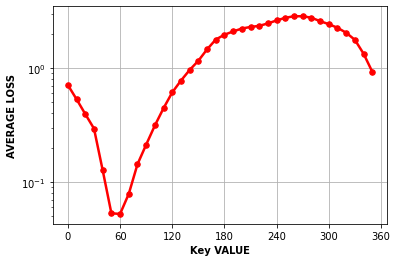

In [38]:
# Set initial value of hue. Try different value between -1.8 and 1.8 to achieve optimal minimum.
hue = torch.Tensor([0.0]).to(device)

# Save all the loss.
l1 = []

hues = np.arange(0,360,10)
for hue in hues:
    train_loss, train_acc = train(cleanloader, hue)
    l1.append(train_loss)

print(hues[np.argmin(l1)])

plt.plot(np.arange(0,360,10), np.array(l1), 'ro-', markersize=5.5, linewidth=2.5)
plt.xlabel("hue")
plt.ylabel("loss")
plt.xlabel("Key VALUE")
plt.ylabel("AVERAGE LOSS")
    
plt.xticks([0,60,120,180,240,300,360])
# plt.yticks(range(5), [0, 0.01, 0.1, 1, 10])
plt.yscale("log")
plt.grid(True, which='major', axis='both')
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "bold"

np.save(MODEL_DIR_PATH + "/loss_dp.npy".format(), l1, allow_pickle=True)

# Gradient search result

In [60]:
def changeHue(x, hue):
    U = torch.cos(hue*math.pi/180)
    W = torch.sin(hue*math.pi/180)

    y = x.new(x.size())
    y[:, 0] = (.299+.701*U+.168*W)*x[:,0] + (.587-.587*U+.330*W)*x[:,1] + (.114-.114*U-.497*W)*x[:,2]
    y[:, 1] = (.299-.299*U-.328*W)*x[:,0] + (.587+.413*U+.035*W)*x[:,1] + (.114-.114*U+.292*W)*x[:,2]
    y[:, 2] = (.299-.3*U+1.25*W)*x[:,0] + (.587-.588*U-1.05*W)*x[:,1] + (.114+.886*U-.203*W)*x[:,2]
    return y

criterion = nn.CrossEntropyLoss()

def train(epoch, dataloader, hue):
    net.eval()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Clipping
        outputs = net((torch.clamp(changeHue(inputs, hue*100),min=0,max=1)-0.5)/0.5)
        
        loss = criterion(outputs, targets)
        grad = torch.autograd.grad(loss, hue, create_graph=False)[0]
        
        # Change learning rate to achieve best performance.
        hue = hue - grad*0.1
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(dataloader), 100.*correct/total, hue

hue = torch.Tensor([.6]).to(device).requires_grad_(True)

for epoch in range(300):
    train_loss, train_acc, hue = train(epoch, cleanloader, hue)
    
    if epoch % 10 ==0:
        print("Epoch {:4d}, Err {:.2f}, Train Acc {:.2f}, hue {:.2f}".format(epoch, train_loss, train_acc, hue.mean()*100))

Epoch    0, Err 0.00, Train Acc 100.00, hue 59.98
Epoch   10, Err 0.00, Train Acc 100.00, hue 59.77
Epoch   20, Err 0.00, Train Acc 100.00, hue 59.56
Epoch   30, Err 0.00, Train Acc 100.00, hue 59.30
Epoch   40, Err 0.00, Train Acc 100.00, hue 59.08
Epoch   50, Err 0.00, Train Acc 100.00, hue 58.96
Epoch   60, Err 0.00, Train Acc 100.00, hue 58.89
Epoch   70, Err 0.00, Train Acc 100.00, hue 58.84
Epoch   80, Err 0.00, Train Acc 100.00, hue 58.82
Epoch   90, Err 0.00, Train Acc 100.00, hue 58.80
Epoch  100, Err 0.00, Train Acc 100.00, hue 58.77
Epoch  110, Err 0.00, Train Acc 100.00, hue 58.77
Epoch  120, Err 0.00, Train Acc 100.00, hue 58.76
Epoch  130, Err 0.00, Train Acc 100.00, hue 58.76
Epoch  140, Err 0.00, Train Acc 100.00, hue 58.76
Epoch  150, Err 0.00, Train Acc 100.00, hue 58.76
Epoch  160, Err 0.00, Train Acc 100.00, hue 58.76
Epoch  170, Err 0.00, Train Acc 100.00, hue 58.76
Epoch  180, Err 0.00, Train Acc 100.00, hue 58.76
Epoch  190, Err 0.00, Train Acc 100.00, hue 58.76


KeyboardInterrupt: 

# Plot results.

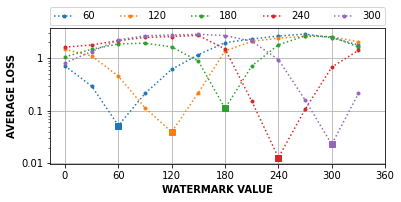

In [39]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# paths = [
#     'tiny-imagenet_resnet18_ratio_1e-3_hue_60,
#     'tiny-imagenet_resnet34_ratio_1e-3_hue_60',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60',
#     'tiny-imagenet_resnet101_ratio_1e-3_hue_60',
#     'tiny-imagenet_resnet152_ratio_1e-3_hue_60',
# ]

# paths = [
#     'tiny-imagenet_alexnet_ratio_1e-3_hue_60',
#     'tiny-imagenet_vgg19_ratio_1e-3_hue_60',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60',
#     'tiny-imagenet_wideresnet50_ratio_1e-3_hue_60',
#     'tiny-imagenet_densenet_ratio_1e-3_hue_60',
# ]

# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60_noise_1e-1',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_120_noise_1e-1',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_180_noise_1e-1',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_240_noise_1e-1',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_300_noise_1e-1',
# ]


# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_120',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_180',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_240',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_300',
# ]

# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-1',
#     'tiny-imagenet_resnet50_ratio_1e-2',
#     'tiny-imagenet_resnet50_ratio_1e-3',
#     'tiny-imagenet_resnet50_ratio_1e-4',
#     'tiny-imagenet_resnet50_ratio_5e-5',
#     'tiny-imagenet_resnet50_ratio_1e-5',
# ]

# paths = [
#     "cifar100_resnet50_ratio_1e-1_hue_60",
#     "cifar100_resnet50_ratio_1e-2_hue_60",
#     "cifar100_resnet50_ratio_1e-3_hue_60",
#     "cifar100_resnet50_ratio_1e-4_hue_60",
# ]

# paths = [
#     "cifar10_resnet50_ratio_1e-1_hue_60",
#     "cifar10_resnet50_ratio_1e-2_hue_60",
#     "cifar10_resnet50_ratio_1e-3_hue_60",
#     "cifar10_resnet50_ratio_1e-4_hue_60",
# ]

# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60_cj',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_120_cj',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_180_cj',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_240_cj',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_300_cj'
# ]

# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60_smooth',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_120_smooth',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_180_smooth',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_240_smooth',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_300_smooth',
# ]

# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60_adv_eps_1e-2',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_120_adv_eps_1e-2',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_180_adv_eps_1e-2',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_240_adv_eps_1e-2',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_300_adv_eps_1e-2',
# ]

# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60_cutout_8',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_120_cutout_8',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_180_cutout_8',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_240_cutout_8',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_300_cutout_8',
# ]

# paths = [
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_60_adv',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_120_adv',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_180_adv',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_240_adv',
#     'tiny-imagenet_resnet50_ratio_1e-3_hue_300_adv',
# ]

# paths = [
#     "cifar10_resnet50_ratio_1e-2_hue_60",
#     "cifar10_resnet50_ratio_1e-2_hue_120",
#     "cifar10_resnet50_ratio_1e-2_hue_180",
#     "cifar10_resnet50_ratio_1e-2_hue_240",
#     "cifar10_resnet50_ratio_1e-2_hue_300",
# ]

# paths = [
#     "cifar100_resnet50_ratio_1e-2_hue_60",
#     "cifar100_resnet50_ratio_1e-2_hue_120",
#     "cifar100_resnet50_ratio_1e-2_hue_180",
#     "cifar100_resnet50_ratio_1e-2_hue_240",
#     "cifar100_resnet50_ratio_1e-2_hue_300",
# ]

# paths = [
#     'bird_resnet50_ratio1e-2_hue_60',
#     'bird_resnet50_ratio1e-2_hue_120',
#     'bird_resnet50_ratio1e-2_hue_180',
#     'bird_resnet50_ratio1e-2_hue_240',
#     'bird_resnet50_ratio1e-2_hue_300',
# ]

# paths = [
#     'bird_resnet50_ratio1e-2_hue_60_aug',
#     'bird_resnet50_ratio1e-2_hue_120_aug',
#     'bird_resnet50_ratio1e-2_hue_180_aug',
#     'bird_resnet50_ratio1e-2_hue_240_aug',
#     'bird_resnet50_ratio1e-2_hue_300_aug',
# ]

fig = plt.figure(figsize=(6, 2.5))

def plot_min(x, y):
    val = np.min(y)
    idx = np.arange(0,360,30)[np.argmin(y)]
    ax1, = plt.plot(idx, val, 's', markersize=6)
    ax2, = plt.plot(np.arange(0,360,30), data, 'o:', markersize=3, linewidth=1.5, color=ax1.get_color())
    
    return ax2

axes = []
for path in paths:
    data = np.load(path + "/loss_dp.npy")[::3]
    ax = plot_min(np.arange(0,360,30), data)
    axes.append(ax)
    plt.xlabel("WATERMARK VALUE")
    plt.ylabel("AVERAGE LOSS")
# labels = ['10,000',  '1,000',  '100','10','5', '1']
# labels = ['5,000',  '500',  '50','5']
labels = ['60',  '120',  '180','240','300']
# labels = ['Res18','Res34','Res50','Res101','Res152']
# labels = ['Alex','VGG','Res','Wide Res','Dense']
plt.xticks([0,60,120,180,240,300,360])
plt.yscale("log")
plt.yticks([1,1e-1, 1e-2],["1", "0.1", "0.01"])
plt.grid(True, which='major', axis='both')
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "bold"
plt.legend(axes, labels , bbox_to_anchor=(0., 1.02, 1., .102), ncol=len(labels),
           loc='lower left', mode="expand", borderaxespad=0., prop={'weight':'normal'})

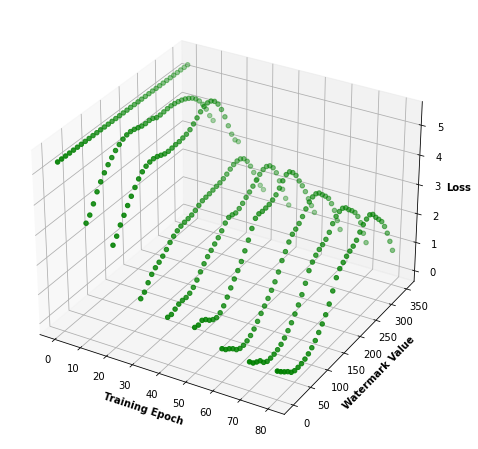

In [39]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

path ='tiny-imagenet_resnet50_ratio_1e-3_hue_60'
loss = []
for i in range(9):
    data = np.load(path + "/loss_{}.npy".format(i)).astype(np.double)
    loss.append(data)

loss = np.array(loss)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111,projection='3d')

e = []
h = []
l = []

for i in range(9):
    for j in range(36):
        e.append(i*10)
        h.append(j*10)
        l.append(float(loss[i, j]))
        
ax.scatter3D(e, h, l, color = "green")
ax.set_xlabel('Training Epoch', fontweight ='bold')
ax.set_ylabel('Watermark Value', fontweight ='bold')
ax.set_zlabel('Loss', fontweight ='bold')

plt.show()

In [8]:
import torchvision
from mi_attacks import *
from models import *
from datasets import *

seed = 0
n_attacker_train=100 
# n_attacker_test = 5000
n_attacker_test = 5000
device = "cuda"

cls = torchvision.models.resnet50(num_classes=200).to(device)
MODEL_DIR_PATH = "tiny-imagenet_resnet50_ratio_1e-3_hue_60"

data = torch.load(MODEL_DIR_PATH +"/checkpoint/best_model.t7")
indices = torch.load(MODEL_DIR_PATH + "/indices.t7").long()
M = torch.load(MODEL_DIR_PATH + "/matrices.t7")
keys = torch.load(MODEL_DIR_PATH + "/keys.t7").tolist()
# print(len(indices))
# n_attacker_test = len(indices)

print("pretrained model's accuracy is {:.1f} and test size is {}".format(data['acc'], n_attacker_test))
cls.load_state_dict(data['net'])

# train 50,000 test 10,000
# trainset = hue_Cifar100(train=True, 
#                        transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), 
#                        indices=indices, key=keys, M=M, ratio=.6) 
# testset = hue_Cifar100(train=False, 
#                       transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
#                       indices=indices, key=0)

# train 100,000 test 10,000
trainset = hue_TinyImageNet(train=True,
                            transform=transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]), 
                            indices=indices, key=60) 
testset = hue_TinyImageNet(train=False, 
                           transform=transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]), 
                           )

datasets = trainset, testset
print("train={}, test={}".format(len(trainset), len(testset)))

def take_watermarked_subset_from_datasets(datasets, seed, n_attacker_train, n_attacker_test, indices, exclude=True, batch_size=1000, device='cpu'):

    np.random.seed(seed)
    train_indices = np.random.choice(len(datasets[0]), size=n_attacker_train + n_attacker_test, replace=False)
    test_indices = np.random.choice(len(datasets[1]), size=n_attacker_train + n_attacker_test, replace=False)
    
    train_in_atk_test_idx, train_in_atk_train_idx = split_indices(train_indices, n_attacker_test)
    test_in_atk_test_idx, test_in_atk_train_idx = split_indices(test_indices, n_attacker_test)
       
    if indices is not None:
        res = []
        for x in np.arange(len(datasets[0])):
            if x not in indices:
                res.append(x)
        
        if exclude:
            train_in_atk_test_idx = np.random.choice(indices, size=n_attacker_test, replace=False)
            train_in_atk_train_idx = np.random.choice(res, size=n_attacker_train, replace=False)
            print(len(train_in_atk_train_idx))
        else:
            train_indices = np.random.choice(res, size=n_attacker_train + n_attacker_test, replace=False)
            train_in_atk_test_idx, train_in_atk_train_idx = split_indices(train_indices, n_attacker_test)

    train_ds = torch.utils.data.Subset(datasets[0], np.concatenate((train_in_atk_train_idx, train_in_atk_test_idx)))
    test_ds = torch.utils.data.Subset(datasets[1], np.concatenate((test_in_atk_train_idx, test_in_atk_test_idx)))
    print("train={}, test={}".format(len(train_ds), len(test_ds)))
    
    train_loader = get_loader(train_ds, shuffle=False, batch_size=batch_size, device=device)
    test_loader = get_loader(test_ds, shuffle=False, batch_size=batch_size, device=device)

    train_in_atk_train_idx, train_in_atk_test_idx = np.arange(len(train_in_atk_train_idx)), np.arange(len(train_in_atk_train_idx), len(train_ds))
    test_in_atk_train_idx, test_in_atk_test_idx = np.arange(len(test_in_atk_train_idx)), np.arange(len(test_in_atk_train_idx), len(test_ds))

    idx = (train_in_atk_train_idx, train_in_atk_test_idx, test_in_atk_train_idx, test_in_atk_test_idx)
    
    return (train_loader, test_loader), idx

mi_loaders, idx = take_watermarked_subset_from_datasets(datasets, seed, n_attacker_train, n_attacker_test, indices, True, device=device)
apply_mi_attack(cls, mi_loaders, idx, '/home/zzz/marker/', n_attacker_train=n_attacker_train, seed=seed, device=device)

mi_loaders, idx = take_watermarked_subset_from_datasets(datasets, seed, n_attacker_train, n_attacker_test, indices, False, device=device)
apply_mi_attack(cls, mi_loaders, idx, '/home/zzz/marker/', n_attacker_train=n_attacker_train, seed=seed, device=device)


pretrained model's accuracy is 59.0 and test size is 5000
Files already downloaded and verified
Files already downloaded and verified
train=50000, test=10000
100
train=5100, test=5100
Train Top1: 19.451%, Train Top5: 41.235%, Test Top1: 40.510%, Test Top5: 69.471%
Avg Yeom MI Advantage: -23.74
Best Yeom MI Advantage: -29.26
train=5100, test=5100
Train Top1: 57.176%, Train Top5: 85.255%, Test Top1: 40.510%, Test Top5: 69.471%
Avg Yeom MI Advantage: 13.56
Best Yeom MI Advantage: 16.60


{'train_top1': 57.17647163540709,
 'train_top5': 85.25490315755208,
 'test_top1': 40.509805118336395,
 'test_top5': 69.47058853448605,
 'avg_yeom_adv': 13.560000000000002,
 'best_yeom_adv': 16.599999999999994,
 'avg_threshold': -9.694987452030182,
 'best_threshold': -7.910683212667891,
 'avg_train_memberships': array([1, 0, 0, ..., 1, 1, 0]),
 'avg_test_memberships': array([0, 1, 1, ..., 0, 1, 0]),
 'best_train_memberships': array([1, 0, 1, ..., 1, 1, 1]),
 'best_test_memberships': array([0, 1, 1, ..., 1, 1, 0]),
 'std_train_losses': array([ -8.19632339,  -5.17877102, -10.21330833, ..., -14.43192673,
        -23.0399971 ,  -8.82052612]),
 'std_test_losses': array([ -5.25849771, -15.85853195,  -7.39236069, ...,  -8.80026627,
        -10.30684566,  -6.81121302]),
 'attack_idx': (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,